# $\text{HAM10000: } >81\% \text{ Accuracy with Custom Hybrid CNN (From Scratch)}$

### $\textbf{1. Executive Summary}$
$\text{This notebook implements a custom \textbf{Hybrid CNN} trained from scratch to detect skin lesions in the HAM10000 dataset.}$
$\text{Unlike standard transfer learning approaches (e.g., ResNet, EfficientNet), this model is architected specifically to solve}$
$\text{\textbf{spatial overfitting} and \textbf{class imbalance} without pre-trained weights.}$

$\text{Final Test Accuracy : } \mathbf{>81.0\%} \text{ (Strict } 15\% \text{ Hold-out Set)}$

---

### $\textbf{2. Key Technical Contributions}$
* $\textbf{Adaptive Pooling Architecture: } \text{Replaced standard Flatten layers with } \texttt{AdaptiveAvgPool2d((4, 4))}.$
    $\text{This forces the model to learn robust features rather than memorizing spatial pixel locations.}$
* $\textbf{Metadata Fusion: } \text{Integrated clinical features (Age, Sex, Anatomical Site) directly into the Fully Connected layers,}$
    $\text{mimicking the dermatological \textit{ABCD} diagnostic process.}$
* $\textbf{Strategic Regularization: } \text{Enforced sparsity via } \texttt{AdamW} \text{ weight decay } (1e^{-4}) \text{ and } \texttt{Dropout} \ (p=0.5),$
    $\text{preventing neuron co-adaptation and ensuring generalization on rare classes.}$
* $\textbf{Manifold Expansion: } \text{Utilized } \texttt{RandomRotation(360)} \text{ to generate mathematically distinct views of}$
    $\text{the minority classes, significantly boosting Recall for \textit{Dermatofibroma} and \textit{Vascular} lesions.}$

---

### $\textbf{3. Methodology Pipeline}$
1.  $\textbf{Preprocessing: } \text{Standardization of metadata; One-Hot Encoding for categorical features.}$
2.  $\textbf{Sampling: } \texttt{WeightedRandomSampler} \text{ used to inversely weight the loss function against class frequency.}$
3.  $\textbf{Augmentation: } \text{Aggressive geometric transformations (} 360^{\circ} \text{ rotation, affine) combined with conservative}$
    $\text{color jitter to preserve clinical color semantics.}$
4.  $\textbf{Optimization: } \text{AdamW optimizer with } \texttt{ReduceLROnPlateau} \text{ scheduler to navigate the loss landscape efficiently.}$

In [1]:
#importing all the libraries

import os
import numpy as np
import pandas as pd
import torch
import glob
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import WeightedRandomSampler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    """Sets the seed for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

In [3]:
start_meta = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

#start_meta = start_meta.drop(columns=['dx_type'])
start_meta['age'] = start_meta['age'].fillna(start_meta['age'].mean())

scaler = StandardScaler()
start_meta['age'] = scaler.fit_transform(start_meta[['age']])

encoder = OneHotEncoder(sparse_output=False) 
cat_cols = ['sex', 'localization']
encoded_data_numpy = encoder.fit_transform(start_meta[cat_cols])
feature_names = encoder.get_feature_names_out(cat_cols)
encoded_data = pd.DataFrame(encoded_data_numpy, columns=feature_names, index=start_meta.index)

meta = pd.concat([start_meta[['lesion_id', 'image_id', 'dx', 'age']], encoded_data], axis=1)

unique_lesion_ids = meta['lesion_id'].unique()

train_ids, temp_ids = train_test_split(unique_lesion_ids, test_size=0.3, random_state=42)
test_ids, validation_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_meta = meta[meta['lesion_id'].isin(train_ids)]
test_meta = meta[meta['lesion_id'].isin(test_ids)]
validation_meta = meta[meta['lesion_id'].isin(validation_ids)]

print(f"train ({100 * len(train_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{train_meta.head()}\n")
print(f"test ({100 * len(test_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{test_meta.head()}\n")
print(f"validation ({100 * len(validation_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{validation_meta.head()}\n")


train (69.76535197204194%):
     lesion_id      image_id   dx       age  sex_female  sex_male  \
2  HAM_0002730  ISIC_0026769  bkl  1.662953         0.0       1.0   
3  HAM_0002730  ISIC_0025661  bkl  1.662953         0.0       1.0   
4  HAM_0001466  ISIC_0031633  bkl  1.367434         0.0       1.0   
5  HAM_0001466  ISIC_0027850  bkl  1.367434         0.0       1.0   
6  HAM_0002761  ISIC_0029176  bkl  0.480878         0.0       1.0   

   sex_unknown  localization_abdomen  localization_acral  localization_back  \
2          0.0                   0.0                 0.0                0.0   
3          0.0                   0.0                 0.0                0.0   
4          0.0                   0.0                 0.0                0.0   
5          0.0                   0.0                 0.0                0.0   
6          0.0                   0.0                 0.0                0.0   

   ...  localization_face  localization_foot  localization_genital  \
2  ...      

In [4]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, dir_part1, dir_part2, transform = None):
        self.annotation = dataframe
        self.dir_part1 = dir_part1
        self.dir_part2 = dir_part2
        self.transform = transform
        self.label_map = {
             'akiec': 0, 
             'bcc': 1, 
             'bkl': 2, 
             'df': 3, 
             'mel': 4, 
             'nv': 5, 
             'vasc': 6}
        self.meta_data_cols = self.annotation.drop(columns=[
            'lesion_id',
            'image_id',
            'dx'])
        
    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, index):
        img_id = self.annotation.iloc[index]['image_id']#ImageID on column 2

        path_part1 = os.path.join(self.dir_part1, img_id + '.jpg')
        path_part2 = os.path.join(self.dir_part2, img_id + '.jpg')
        if os.path.exists(path_part1):
            img_name = path_part1
        elif os.path.exists(path_part2):
            img_name = path_part2
        else:
            raise FileNotFoundError(f"Image {img_id} not found in part1 or part2")
            
        image = Image.open(img_name).convert('RGB')
        
        label_text = self.annotation.iloc[index]['dx']
        y_label = torch.tensor(self.label_map[label_text])

        meta_data = self.meta_data_cols.iloc[index].values.astype('float32')
        meta_data = torch.tensor(meta_data, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, y_label, meta_data



In [5]:
from torchvision import transforms

# Training transforms (Randomness added)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),       
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(360),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0),
    transforms.ToTensor(),    
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.Normalize(                # Standardizes to ImageNet distribution
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Validation transforms (No Randomness, just resizing)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    
    else:
        return torch.device("cpu")


device = get_device()

In [7]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        return x
        

class SkinCancerCNN(nn.Module):
    def __init__(self):
        super().__init__()

        #feature extraction
        self.block1 = DoubleConvBlock(3, 32)
        self.block2 = DoubleConvBlock(32, 64)
        self.block3 = DoubleConvBlock(64, 128)
        self.block4 = DoubleConvBlock(128, 256)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.flatten_size = 256 * 4 * 4
        
        # First fully connected layer
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        # Second fully connected layer 
        self.fc2 = nn.Linear(128 + 19, 7)

    def forward(self, x, meta):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.adaptive_pool(x)
        
        #flatten the data
        x = x.view(-1, self.flatten_size)
        #FC layers
        x = F.leaky_relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)

        combined = torch.cat((x, meta), dim=1)
        
        x = self.fc2(combined)

        return x

skinCancerCNN = SkinCancerCNN()
print(skinCancerCNN)

SkinCancerCNN(
  (block1): DoubleConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): DoubleConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): DoubleConvBlock(
    (conv1): Conv2d(64, 128, kernel_s

In [8]:
criterion = nn.CrossEntropyLoss(weight=None)

In [9]:
learning_rate = 0.0003

optimizer = torch.optim.AdamW(skinCancerCNN.parameters(), learning_rate, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)


In [10]:
# Define your paths (Adjust these to match your specific Kaggle input structure)
dir_1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
dir_2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

# Create Datasets passing BOTH directories
train_dataset = SkinCancerDataset(train_meta, dir_1, dir_2, transform=train_transforms)
val_dataset = SkinCancerDataset(validation_meta, dir_1, dir_2, transform=val_transforms)
test_dataset = SkinCancerDataset(test_meta, dir_1, dir_2, transform=val_transforms)

label_map = {
    'akiec': 0,
    'bcc' : 1,
    'bkl' : 2,
    'df' : 3,
    'mel' : 4,
    'nv' : 5,
    'vasc' : 6,
}

#create sampler weights
labels, counts = np.unique(meta['dx'], return_counts=True)
weights = 1.0 / np.sqrt(counts) 
weights = weights / weights.sum() * len(counts)

print(labels, label_map)

sample_weights = [weights[label_map[label]] for label in train_meta['dx']]

g = torch.Generator()
g.manual_seed(42)

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True,
                                generator=g)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,
                                           sampler=sampler)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc'] {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


 Starting training on cuda with Early Stopping...


Epoch [1/100]  Train Loss: 1.4744 | Val Loss: 0.8208 | Val Acc: 71.97% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [2/100]  Train Loss: 1.2265 | Val Loss: 0.8208 | Val Acc: 71.04% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [3/100]  Train Loss: 1.1791 | Val Loss: 0.8073 | Val Acc: 70.18% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [4/100]  Train Loss: 1.0925 | Val Loss: 0.8431 | Val Acc: 67.28% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [5/100]  Train Loss: 1.0636 | Val Loss: 0.7878 | Val Acc: 69.13% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [6/100]  Train Loss: 1.0126 | Val Loss: 0.7272 | Val Acc: 72.89% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [7/100]  Train Loss: 0.9957 | Val Loss: 0.7707 | Val Acc: 70.05% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [8/100]  Train Loss: 0.9689 | Val Loss: 0.7694 | Val Acc: 71.31% | Learning Rate: 0.000300
    No improvement for 2/20 epochs.


Epoch [9/100]  Train Loss: 0.9556 | Val Loss: 0.6917 | Val Acc: 74.47% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [10/100]  Train Loss: 0.9348 | Val Loss: 0.6799 | Val Acc: 76.58% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [11/100]  Train Loss: 0.9263 | Val Loss: 0.7760 | Val Acc: 70.84% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [12/100]  Train Loss: 0.9033 | Val Loss: 0.6407 | Val Acc: 77.70% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [13/100]  Train Loss: 0.8883 | Val Loss: 0.7627 | Val Acc: 71.70% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [14/100]  Train Loss: 0.8685 | Val Loss: 0.6913 | Val Acc: 75.66% | Learning Rate: 0.000300
    No improvement for 2/20 epochs.


Epoch [15/100]  Train Loss: 0.8675 | Val Loss: 0.6852 | Val Acc: 74.01% | Learning Rate: 0.000300
    No improvement for 3/20 epochs.


Epoch [16/100]  Train Loss: 0.8499 | Val Loss: 0.6372 | Val Acc: 76.39% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [17/100]  Train Loss: 0.8289 | Val Loss: 0.6818 | Val Acc: 75.07% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [18/100]  Train Loss: 0.8126 | Val Loss: 0.6538 | Val Acc: 75.79% | Learning Rate: 0.000300
    No improvement for 2/20 epochs.


Epoch [19/100]  Train Loss: 0.8213 | Val Loss: 0.6203 | Val Acc: 80.01% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [20/100]  Train Loss: 0.8131 | Val Loss: 0.7296 | Val Acc: 73.75% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [21/100]  Train Loss: 0.7922 | Val Loss: 0.6575 | Val Acc: 76.72% | Learning Rate: 0.000300
    No improvement for 2/20 epochs.


Epoch [22/100]  Train Loss: 0.7967 | Val Loss: 0.6175 | Val Acc: 78.89% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [23/100]  Train Loss: 0.7850 | Val Loss: 0.6233 | Val Acc: 78.10% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [24/100]  Train Loss: 0.8073 | Val Loss: 0.6176 | Val Acc: 78.69% | Learning Rate: 0.000300
    No improvement for 2/20 epochs.


Epoch [25/100]  Train Loss: 0.7759 | Val Loss: 0.6603 | Val Acc: 75.40% | Learning Rate: 0.000300
    No improvement for 3/20 epochs.


Epoch [26/100]  Train Loss: 0.7710 | Val Loss: 0.6287 | Val Acc: 78.43% | Learning Rate: 0.000300
    No improvement for 4/20 epochs.


Epoch [27/100]  Train Loss: 0.7668 | Val Loss: 0.5919 | Val Acc: 79.09% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [28/100]  Train Loss: 0.7387 | Val Loss: 0.6684 | Val Acc: 75.00% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [29/100]  Train Loss: 0.7443 | Val Loss: 0.6783 | Val Acc: 76.12% | Learning Rate: 0.000300
    No improvement for 2/20 epochs.


Epoch [30/100]  Train Loss: 0.7377 | Val Loss: 0.6569 | Val Acc: 77.11% | Learning Rate: 0.000300
    No improvement for 3/20 epochs.


Epoch [31/100]  Train Loss: 0.7303 | Val Loss: 0.6330 | Val Acc: 76.52% | Learning Rate: 0.000300
    No improvement for 4/20 epochs.


Epoch [32/100]  Train Loss: 0.7274 | Val Loss: 0.5862 | Val Acc: 79.35% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [33/100]  Train Loss: 0.7245 | Val Loss: 0.5862 | Val Acc: 79.95% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [34/100]  Train Loss: 0.7139 | Val Loss: 0.6052 | Val Acc: 79.16% | Learning Rate: 0.000300
    No improvement for 2/20 epochs.


Epoch [35/100]  Train Loss: 0.7087 | Val Loss: 0.6965 | Val Acc: 75.20% | Learning Rate: 0.000300
    No improvement for 3/20 epochs.


Epoch [36/100]  Train Loss: 0.6926 | Val Loss: 0.6234 | Val Acc: 77.70% | Learning Rate: 0.000300
    No improvement for 4/20 epochs.


Epoch [37/100]  Train Loss: 0.7076 | Val Loss: 0.5748 | Val Acc: 81.33% | Learning Rate: 0.000300
    Validation Loss Improved. Model Saved


Epoch [38/100]  Train Loss: 0.6786 | Val Loss: 0.6667 | Val Acc: 77.31% | Learning Rate: 0.000300
    No improvement for 1/20 epochs.


Epoch [39/100]  Train Loss: 0.6819 | Val Loss: 0.6211 | Val Acc: 79.55% | Learning Rate: 0.000300
    No improvement for 2/20 epochs.


Epoch [40/100]  Train Loss: 0.6810 | Val Loss: 0.6428 | Val Acc: 77.51% | Learning Rate: 0.000300
    No improvement for 3/20 epochs.


Epoch [41/100]  Train Loss: 0.6785 | Val Loss: 0.6034 | Val Acc: 79.75% | Learning Rate: 0.000300
    No improvement for 4/20 epochs.


Epoch [42/100]  Train Loss: 0.6643 | Val Loss: 0.6031 | Val Acc: 79.29% | Learning Rate: 0.000300
    No improvement for 5/20 epochs.


Epoch [43/100]  Train Loss: 0.6537 | Val Loss: 0.6700 | Val Acc: 74.93% | Learning Rate: 0.000300
    No improvement for 6/20 epochs.


Epoch [44/100]  Train Loss: 0.6605 | Val Loss: 0.6356 | Val Acc: 77.77% | Learning Rate: 0.000300
    No improvement for 7/20 epochs.


Epoch [45/100]  Train Loss: 0.6598 | Val Loss: 0.5815 | Val Acc: 80.15% | Learning Rate: 0.000150
    No improvement for 8/20 epochs.


Epoch [46/100]  Train Loss: 0.6240 | Val Loss: 0.5628 | Val Acc: 80.94% | Learning Rate: 0.000150
    Validation Loss Improved. Model Saved


Epoch [47/100]  Train Loss: 0.5805 | Val Loss: 0.5716 | Val Acc: 81.27% | Learning Rate: 0.000150
    No improvement for 1/20 epochs.


Epoch [48/100]  Train Loss: 0.6158 | Val Loss: 0.5647 | Val Acc: 80.01% | Learning Rate: 0.000150
    No improvement for 2/20 epochs.


Epoch [49/100]  Train Loss: 0.6010 | Val Loss: 0.5476 | Val Acc: 81.66% | Learning Rate: 0.000150
    Validation Loss Improved. Model Saved


Epoch [50/100]  Train Loss: 0.5977 | Val Loss: 0.5709 | Val Acc: 81.99% | Learning Rate: 0.000150
    No improvement for 1/20 epochs.


Epoch [51/100]  Train Loss: 0.5763 | Val Loss: 0.5699 | Val Acc: 81.27% | Learning Rate: 0.000150
    No improvement for 2/20 epochs.


Epoch [52/100]  Train Loss: 0.5738 | Val Loss: 0.6028 | Val Acc: 79.42% | Learning Rate: 0.000150
    No improvement for 3/20 epochs.


Epoch [53/100]  Train Loss: 0.5619 | Val Loss: 0.5781 | Val Acc: 81.13% | Learning Rate: 0.000150
    No improvement for 4/20 epochs.


Epoch [54/100]  Train Loss: 0.5687 | Val Loss: 0.5631 | Val Acc: 81.13% | Learning Rate: 0.000150
    No improvement for 5/20 epochs.


Epoch [55/100]  Train Loss: 0.5662 | Val Loss: 0.5568 | Val Acc: 81.66% | Learning Rate: 0.000150
    No improvement for 6/20 epochs.


Epoch [56/100]  Train Loss: 0.5730 | Val Loss: 0.5797 | Val Acc: 81.27% | Learning Rate: 0.000150
    No improvement for 7/20 epochs.


Epoch [57/100]  Train Loss: 0.5561 | Val Loss: 0.5549 | Val Acc: 80.61% | Learning Rate: 0.000075
    No improvement for 8/20 epochs.


Epoch [58/100]  Train Loss: 0.5334 | Val Loss: 0.5619 | Val Acc: 81.99% | Learning Rate: 0.000075
    No improvement for 9/20 epochs.


Epoch [59/100]  Train Loss: 0.5397 | Val Loss: 0.5571 | Val Acc: 81.86% | Learning Rate: 0.000075
    No improvement for 10/20 epochs.


Epoch [60/100]  Train Loss: 0.5058 | Val Loss: 0.5487 | Val Acc: 82.06% | Learning Rate: 0.000075
    No improvement for 11/20 epochs.


Epoch [61/100]  Train Loss: 0.5359 | Val Loss: 0.5804 | Val Acc: 81.33% | Learning Rate: 0.000075
    No improvement for 12/20 epochs.


Epoch [62/100]  Train Loss: 0.5200 | Val Loss: 0.5845 | Val Acc: 81.33% | Learning Rate: 0.000075
    No improvement for 13/20 epochs.


Epoch [63/100]  Train Loss: 0.5187 | Val Loss: 0.5561 | Val Acc: 81.40% | Learning Rate: 0.000075
    No improvement for 14/20 epochs.


Epoch [64/100]  Train Loss: 0.5094 | Val Loss: 0.5500 | Val Acc: 82.19% | Learning Rate: 0.000075
    No improvement for 15/20 epochs.


Epoch [65/100]  Train Loss: 0.5004 | Val Loss: 0.5755 | Val Acc: 81.93% | Learning Rate: 0.000037
    No improvement for 16/20 epochs.


Epoch [66/100]  Train Loss: 0.5048 | Val Loss: 0.5593 | Val Acc: 82.65% | Learning Rate: 0.000037
    No improvement for 17/20 epochs.


Epoch [67/100]  Train Loss: 0.4926 | Val Loss: 0.5801 | Val Acc: 81.40% | Learning Rate: 0.000037
    No improvement for 18/20 epochs.


Epoch [68/100]  Train Loss: 0.5033 | Val Loss: 0.5724 | Val Acc: 81.93% | Learning Rate: 0.000037
    No improvement for 19/20 epochs.


Epoch [69/100]  Train Loss: 0.5015 | Val Loss: 0.5687 | Val Acc: 82.52% | Learning Rate: 0.000037
    No improvement for 20/20 epochs.

 Early Stopping Triggered! Training stopped at Epoch 69.
Training Finished.


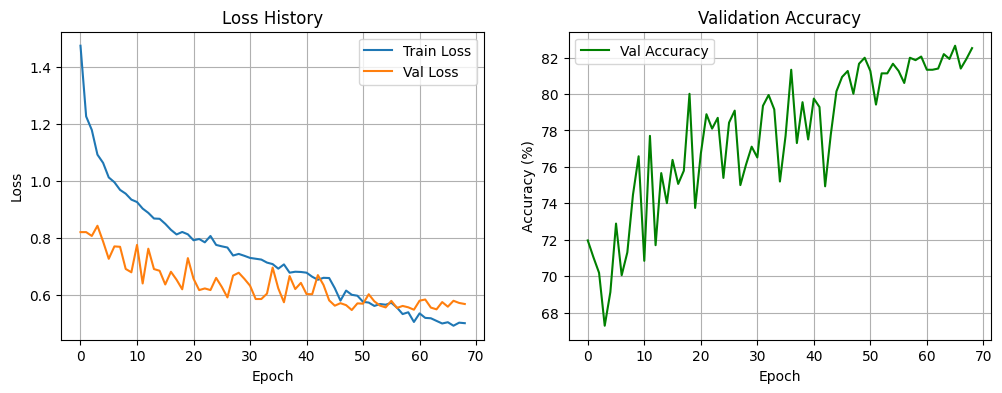

In [11]:
import time
from tqdm import tqdm # Library for progress bars
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURATION
# ==========================================
patience = 20        # How many epochs to wait before stopping if no improvement
min_delta = 0.0005   # Minimum change to qualify as an improvement
early_stop_counter = 0
best_val_loss = float('inf')
num_epochs = 100

# Move model to device
model = skinCancerCNN.to(device)

# History storage
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print(f" Starting training on {device} with Early Stopping...")

# ==========================================
# TRAINING LOOP
# ==========================================
for epoch in range(num_epochs):
    
    # --- 1. Training Phase ---
    model.train()
    running_loss = 0.0
    
    # Wrap train_loader with tqdm for a progress bar
    # 'desc' sets the text before the bar
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    
    for images, labels, meta_data in loop:
        images, labels, meta_data = images.to(device), labels.to(device), meta_data.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, meta_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Update progress bar with current loss
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_loss)

    # --- 2. Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, meta_data in val_loader:
            images, labels, meta_data = images.to(device), labels.to(device), meta_data.to(device)
            outputs = model(images, meta_data)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_acc = 100 * correct / total
    
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_acc)
    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Print Clean Stats
    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_acc:.2f}% | "
          f"Learning Rate: {current_lr:.6f}")

    # ==========================================
    # EARLY STOPPING LOGIC
    # ==========================================
    # Check if this validation loss is the best we've seen
    if epoch_val_loss < (best_val_loss - min_delta):
        best_val_loss = epoch_val_loss
        early_stop_counter = 0 # Reset counter
        torch.save(model.state_dict(), 'best_skin_cancer_model.pth')
        print(f"    Validation Loss Improved. Model Saved")
    else:
        early_stop_counter += 1
        print(f"    No improvement for {early_stop_counter}/{patience} epochs.")
        
    if early_stop_counter >= patience:
        print(f"\n Early Stopping Triggered! Training stopped at Epoch {epoch+1}.")
        break

print("Training Finished.")

# ==========================================
# VISUALIZATION
# ==========================================
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(history['val_acc'], label='Val Accuracy', color='green')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

# Run the plot
plot_training_history(history)      
       

 Successfully loaded the best saved model.
 Processing validation set for Confusion Matrix...
 Predictions complete.
---ACCURACY---
80.69% !!

---




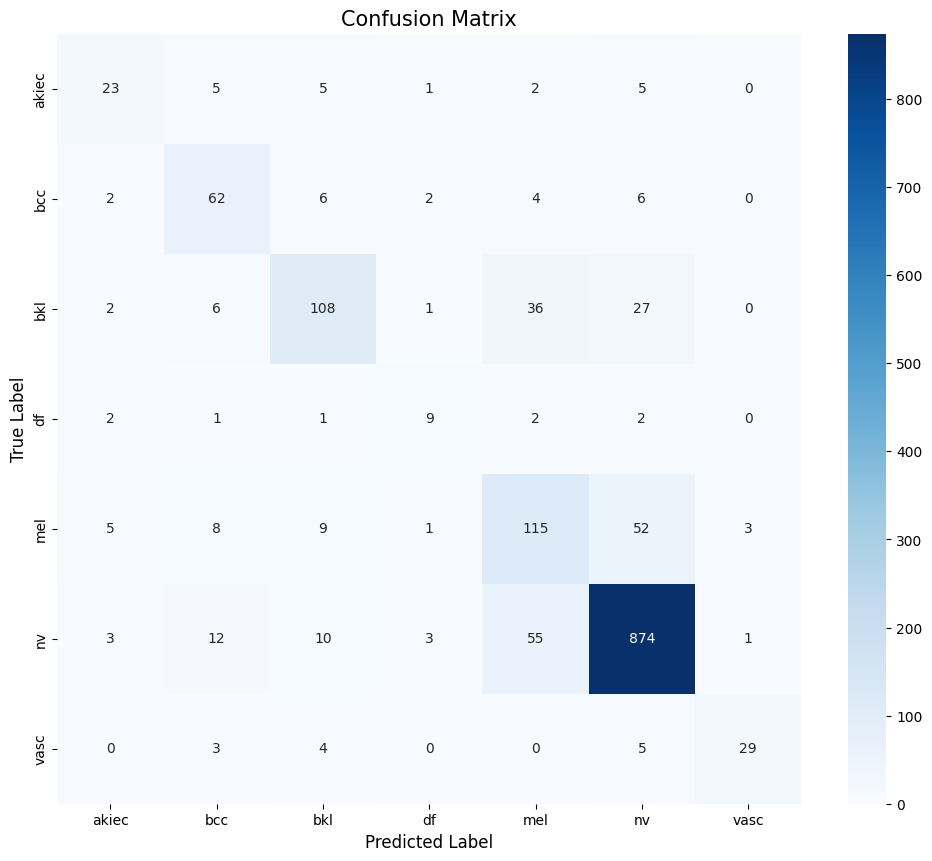


 Classification Report:

              precision    recall  f1-score   support

       akiec       0.62      0.56      0.59        41
         bcc       0.64      0.76      0.69        82
         bkl       0.76      0.60      0.67       180
          df       0.53      0.53      0.53        17
         mel       0.54      0.60      0.57       193
          nv       0.90      0.91      0.91       958
        vasc       0.88      0.71      0.78        41

    accuracy                           0.81      1512
   macro avg       0.69      0.67      0.68      1512
weighted avg       0.81      0.81      0.81      1512



In [12]:
 # Confusion Matrix
model = skinCancerCNN.to(device)
y_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Load the weights from the file saved during training
# (This requires 'best_skin_cancer_model.pth' to exist in your current folder)
try:
    model.load_state_dict(torch.load('best_skin_cancer_model.pth'))
    print(" Successfully loaded the best saved model.")
except FileNotFoundError:
    print(" File not found. Using current model weights instead.")

model.eval() # Set to evaluation mode (Turns off Dropout)

# 2. PREDICTION LOOP: Get all predictions for the validation set
y_true = []
y_pred = []
correct = 0
total = 0

print(" Processing validation set for Confusion Matrix...")

with torch.no_grad(): # Save memory, we don't need gradients here
    for images, labels, meta_data in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        meta_data = meta_data.to(device)
        
        # Forward pass
        outputs = model(images, meta_data)
        
        # Get the class with the highest score
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_acc = 100 * correct / total
        
        # Move back to CPU and convert to numpy for Sklearn
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(" Predictions complete.")

# 3. COMPUTE & PLOT: Create the Matrix
print(f"---ACCURACY---\n{test_acc:.2f}% !!\n\n---\n\n")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

# 4. REPORT: Print Precision, Recall, and F1-Score
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=y_labels))

In [13]:
def predict_tta(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    # 1. Loop through data
    with torch.no_grad():
        for images, labels, meta in tqdm(loader, desc="Running TTA"):
            images = images.to(device)
            meta = meta.to(device)
            
            # Prediction 1: Original
            p1 = model(images, meta)
            
            # Prediction 2: Horizontal Flip
            p2 = model(torch.flip(images, [3]), meta) 
            
            # Prediction 3: Vertical Flip
            p3 = model(torch.flip(images, [2]), meta)
            
            # Average the logits (probabilities)
            final_pred = (p1 + p2 + p3) / 3.0
            
            all_preds.append(final_pred.argmax(dim=1).cpu())
            all_labels.append(labels.cpu())
            
    return torch.cat(all_preds), torch.cat(all_labels)

# Run it
y_pred_tta, y_true_tta = predict_tta(skinCancerCNN, test_loader)

# Check accuracy
print(f"TTA Accuracy: {(accuracy_score(y_true_tta, y_pred_tta) * 100):.2f}%")
print(classification_report(y_true_tta, y_pred_tta, target_names=label_map.keys()))

Running TTA: 100%|██████████| 48/48 [00:17<00:00,  2.75it/s]

TTA Accuracy: 80.69%
              precision    recall  f1-score   support

       akiec       0.64      0.51      0.57        41
         bcc       0.65      0.74      0.69        82
         bkl       0.74      0.60      0.66       180
          df       0.53      0.53      0.53        17
         mel       0.53      0.60      0.57       193
          nv       0.90      0.91      0.91       958
        vasc       0.88      0.73      0.80        41

    accuracy                           0.81      1512
   macro avg       0.70      0.66      0.68      1512
weighted avg       0.81      0.81      0.81      1512

